# Socio-demographic data analysis

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, BatchNormalization, Dropout, Activation, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.__version__

'2.1.0'

In [3]:
from clr_callback import CyclicLR

In [4]:
%matplotlib inline

## Load the dataset

In [5]:
df = pd.read_csv("data/user_exo_2M.csv", sep=",")

In [6]:
df.head()

,yob,domain,firstname,zipcode,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961,@sfr.fr,7ff135854376850,78580.0,M
2,1977,@free.fr,172522ec1028ab7,62640.0,NaN
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN


## Enrich data

In [7]:
df_splitted = df["domain"].str.split(".", expand=True)
df["domain_provider"] = df_splitted[0]
df["domain_origin"] = df_splitted[1]

In [8]:
df["departement"] = df["zipcode"].astype(str).str.slice(start=0, stop=2)
df.loc[df["departement"] == "na", "departement"] = np.nan
df.loc[df["departement"] == "0.", ["departement", "zipcode"]] = np.nan
df["departement"] = df["departement"].astype(float)

In [9]:
df.loc[df["yob"] == -1, "yob"] = np.nan

## Exploration

In [10]:
(df.isnull().sum() / len(df) * 100)

yob                40.00000
domain              0.00000
firstname           0.00000
zipcode             0.94485
gender             40.24770
domain_provider     0.00000
domain_origin       0.00000
departement         0.94485
dtype: float64

Text(0.5, 1.0, 'Percentage of missing values')

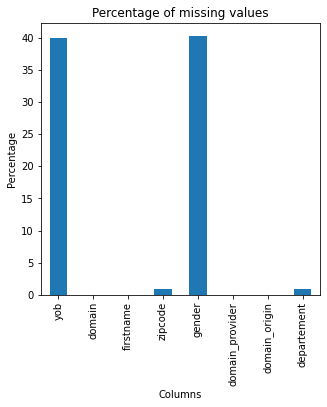

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
(df.isnull().sum() / len(df) * 100).plot.bar(ax=ax)
plt.xlabel("Columns")
plt.ylabel("Percentage")
plt.title("Percentage of missing values")

Text(0.5, 1.0, 'Distribution of Year of birth')

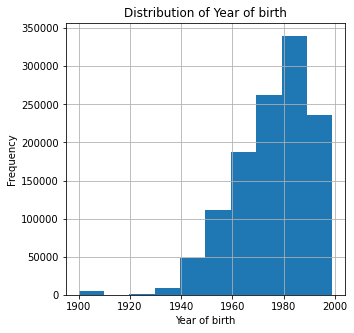

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
df["yob"].hist(ax=ax)
plt.xlabel("Year of birth")
plt.ylabel("Frequency")
plt.title("Distribution of Year of birth")

Text(0.5, 1.0, 'Distribution of Gender')

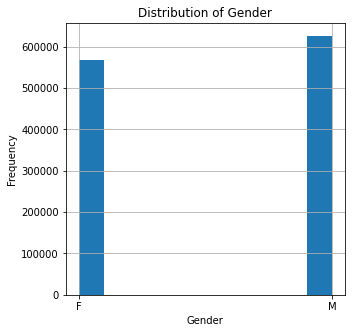

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
df["gender"].hist(ax=ax)
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Distribution of Gender")

Text(0.5, 1.0, 'Distribution of Departement')

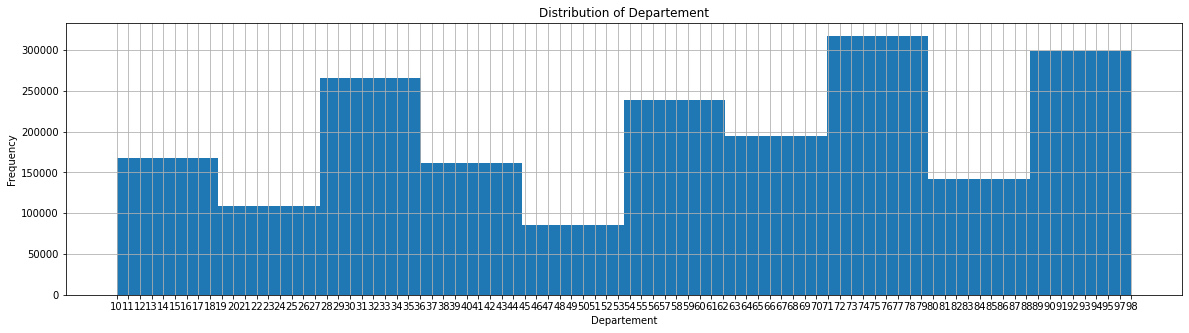

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
df.loc[~df["departement"].isnull(), "departement"].astype(int).astype(str).sort_values().hist(ax=ax)
plt.xlabel("Departement")
plt.ylabel("Frequency")
plt.title("Distribution of Departement")

Text(0.5, 1.0, 'Distribution of domain provider')

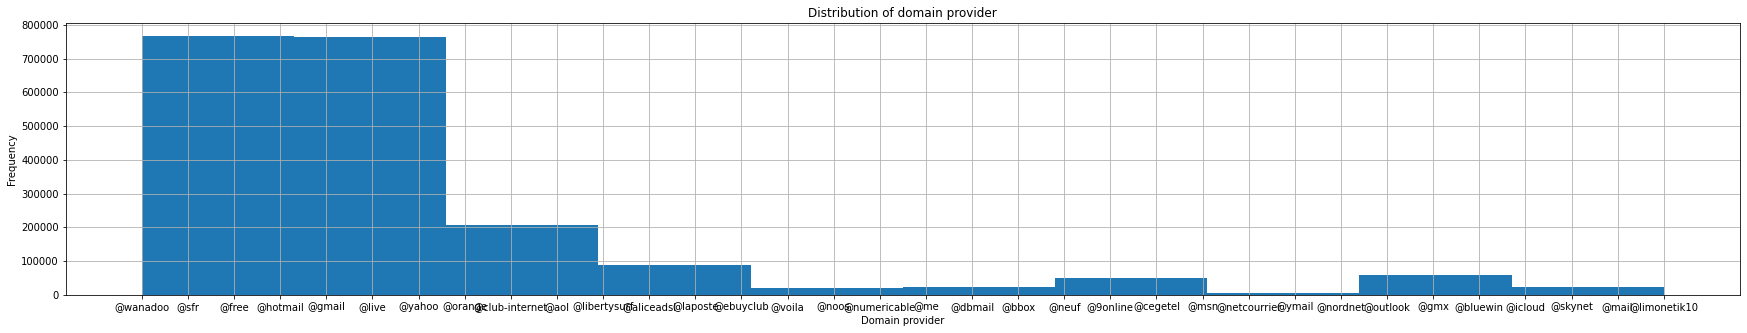

In [15]:
fig, ax = plt.subplots(figsize=(30, 5))
df["domain_provider"].hist(ax=ax)
plt.xlabel("Domain provider")
plt.ylabel("Frequency")
plt.title("Distribution of domain provider")

Text(0.5, 1.0, 'Distribution of domain origin')

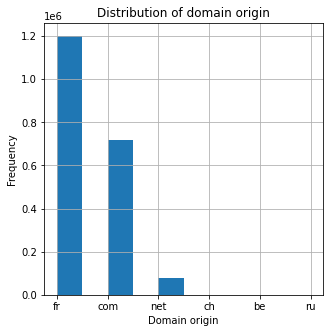

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
df["domain_origin"].hist(ax=ax)
plt.xlabel("Domain origin")
plt.ylabel("Frequency")
plt.title("Distribution of domain origin")

Text(0.5, 1.0, 'Distribution of firstname')

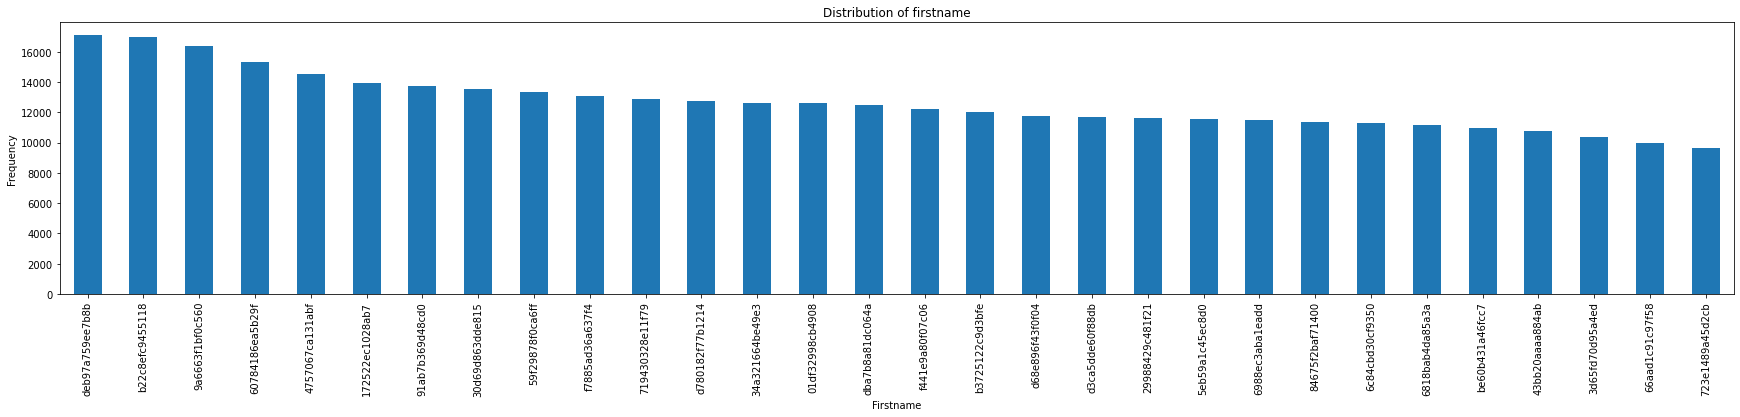

In [17]:
fig, ax = plt.subplots(figsize=(30, 5))
df.groupby(["firstname"]).size().sort_values(ascending=False).head(30).plot.bar(ax=ax)
plt.xlabel("Firstname")
plt.ylabel("Frequency")
plt.title("Distribution of firstname")

## Replace missing zip codes

In [18]:
df.loc[df["zipcode"].isnull(), "zipcode"] =  df["zipcode"].mean()
df.loc[df["departement"].isnull(), "departement"] =  df["departement"].mean()

In [19]:
features = ["zipcode"]

## Encoding

In [20]:
def binary_encoder(dt, col, encoded_values, nb_bits):
    '''
    Separate the specified column into n columns, one for each character of
    the first row of the column (excepted the first and last character)

    Args:
        dt(pandas.DataFrame): The data
        col(str): The name of the column to be separated
        encoded_values(list of string): the Base N encoded values
        nb_bits(int): number of bits in codes

    Returns:
        bool: True if successfull
    '''
    for i in range(nb_bits):
        col_name = col + '_' + (str)(i)
        dt.loc[:, col_name] = [int(encoded_value[i]) for encoded_value in encoded_values]

    return True


def gray_code_encoder(n):
    '''
    Calculate all gray code encodings with a n bit vector

    Args:
        n(int): The number of bits of the encoding vector

    Returns:
        list of str: The encoded list of gray code
    '''
    if n == 0:
        return ['']

    code1 = gray_code_encoder(n - 1)
    code2 = []
    for codeWord in code1:
        code2 = [codeWord] + code2

    for i in range(len(code1)):
        code1[i] += '0'

    for i in range(len(code2)):
        code2[i] += '1'

    return code1 + code2


def gray_code(dt, column, values):
    '''
    Save the information of the column <column> of the pandas.DataFrame <dt> into a
    Gray code encoder, stored into N columns named : <column>_gray_<i> with i between 1 and N.
    
    Args:
        dt(pandas.DataFrame): The data
        column(str): The name of the column to encode
        values(list): all possible values

    Returns:
        bool: True if successfull
    '''
    column_name = column + '_gray'
    length = len(values)
    nb_bits = (length - 1).bit_length()
    print("%d bits needed to encode %d values for column %s" % (nb_bits, length, column))

    code = gray_code_encoder(nb_bits)
    encoded_values = [code[values.index(value)] if value == value else code[values.index('default')] for value in dt[column]]
    return binary_encoder(dt, column_name, encoded_values, nb_bits)

### Encode the domain

In [21]:
possible_values = sorted(df["domain"].unique().tolist())

In [22]:
gray_code(df, "domain", possible_values)

6 bits needed to encode 43 values for column domain


True

In [23]:
features += [col for col in df.columns if "domain" in col and "gray" in col]

### Encode the firstname

In [24]:
possible_values = sorted(df["firstname"].unique().tolist())

In [25]:
gray_code(df, "firstname", possible_values)

14 bits needed to encode 15682 values for column firstname


True

In [26]:
features += [col for col in df.columns if "firstname" in col and "gray" in col]

## Features normalization

In [27]:
features

['zipcode',
 'domain_gray_0',
 'domain_gray_1',
 'domain_gray_2',
 'domain_gray_3',
 'domain_gray_4',
 'domain_gray_5',
 'firstname_gray_0',
 'firstname_gray_1',
 'firstname_gray_2',
 'firstname_gray_3',
 'firstname_gray_4',
 'firstname_gray_5',
 'firstname_gray_6',
 'firstname_gray_7',
 'firstname_gray_8',
 'firstname_gray_9',
 'firstname_gray_10',
 'firstname_gray_11',
 'firstname_gray_12',
 'firstname_gray_13']

In [28]:
mean = df[features].mean(axis=0)
std = df[features].std(axis=0)

In [29]:
df[features] = (df[features] - mean) / std

## Gender dataset building

In [30]:
train_val_gender = df[~df["gender"].isnull()].reset_index(drop=True)
test_gender = df[df["gender"].isnull()].copy()

train_indicices = np.random.randint(0, len(train_val_gender), size=int(len(train_val_gender) * 0.8))

train_gender = train_val_gender.iloc[train_indicices].copy()
val_gender = train_val_gender.loc[~train_val_gender.index.isin(train_indicices)].copy()

## Gender column one hot encoding

In [31]:
def one_hot_encoder(x, possible_values):
    '''
    One hot encoder

    Args:
        x(keras tensor): Tensor contraining values to encode
        possible_values(list): list of possible values

    Returns:
        (keras tensor): one hot encoded tensor
    '''
    one_hot_tensors = list()
    for possible_value in possible_values:
        one_hot_tensor = cast(x == possible_value, dtype=tf.float32)
        one_hot_tensors.append(one_hot_tensor)
    
    return tf.concat(one_hot_tensors, axis=-1)

def cast(x, dtype):
    '''
    Cast values to dtype
    
    Args:
        x(keras tensor or numpy.ndarray): The values to cast
        dtype(tensorflow dtype): The dtype to cast values to
        
    Returns:
        keras tensor: casted values
    '''
    if type(x) == np.ndarray and dtype == tf.string:
        x = x.astype(str)
        
    if type(x) == list and dtype == tf.string:
        x = np.array(x).astype(str)
    
    return tf.cast(x, dtype)

In [32]:
possible_labels = sorted(list(set(
    train_gender["gender"].unique().tolist()
    + val_gender["gender"].unique().tolist()
)))

In [33]:
possible_labels

['F', 'M']

In [34]:
train_gender["gender_hot_encoded"] = one_hot_encoder(train_gender[["gender"]].values, possible_labels).numpy()[:, 0].tolist()
val_gender["gender_hot_encoded"] = one_hot_encoder(val_gender[["gender"]].values, possible_labels).numpy()[:, 0].tolist()

## Gender model network definition

In [35]:
K.clear_session()

In [36]:
hidden_activation = 'tanh'
n_hidden = 64
n_layers = 2
drop_prob = 0
batch_normalization = True

In [37]:
main_input = Input(shape=(len(features)), dtype=tf.float32, name="main_input")

X = main_input

for i in range(n_layers):

    X = Dense(n_hidden, name='dense_'+str(i))(X)
    X = BatchNormalization(axis=-1, name='batch_normalization_'+str(i))(X) if batch_normalization else Activation("linear", name='main_identity_'+str(i))(X)
    X = Activation(hidden_activation, name='activation_'+str(i))(X)
    X = Dropout(drop_prob, name='dropout_'+str(i))(X)

output = Dense(1, activation="sigmoid", name="output")(X)

model_gender = Model(inputs=main_input, outputs=output)

model_gender.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 21)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                1408      
_________________________________________________________________
batch_normalization_0 (Batch (None, 64)                256       
_________________________________________________________________
activation_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256   

In [38]:
model_gender.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [39]:
epochs = 1000
batch_size = 500
patience = 20
lr = 0.001

In [40]:
mcp_save = ModelCheckpoint("./model_gender", save_best_only=True, monitor='val_loss', mode='min', save_freq='epoch')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)
clr_callback = CyclicLR(
    base_lr=lr*0.5,
    max_lr=lr*1.5,
    step_size=5*len(train_gender)/batch_size,
    mode='triangular'
)
callbacks = [mcp_save, early_stopping, clr_callback]

In [41]:
history = model_gender.fit(train_gender[features], train_gender["gender_hot_encoded"], shuffle=True, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_gender[features], val_gender["gender_hot_encoded"]), verbose=1, callbacks=callbacks)

Train on 956036 samples, validate on 537200 samples
Epoch 1/1000
953000/956036 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.7984WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_gender/assets
956036/956036 [==============================] - 6s 7us/sample - loss: 0.4425 - accuracy: 0.7986 - val_loss: 0.3260 - val_accuracy: 0.8720
Epoch 2/1000
956036/956036 [==============================] - 6s 6us/sample - loss: 0.2947 - accuracy: 0.8903 - val_loss: 0.2731 - val_accuracy: 0.9019
Epoch 3/1000
956036/956036 [==============================] - 6s 6us/sample - loss: 0.2630 - acc

In [42]:
model_gender = load_model("./model_gender")

In [43]:
train_gender["is_female_probability"] = model_gender.predict(train_gender[features])
val_gender["is_female_probability"] = model_gender.predict(val_gender[features])
test_gender["is_female_probability"] = model_gender.predict(test_gender[features])

In [44]:
df_gender = pd.concat([train_gender, val_gender, test_gender], axis=0)

In [45]:
features += ["is_female_probability"]

## Year of birth dataset building

In [46]:
train_val_yob = df_gender[~df_gender["yob"].isnull()].reset_index(drop=True)
test_yob = df_gender[df_gender["yob"].isnull()].copy()

train_indicices = np.random.randint(0, len(train_val_yob), size=int(len(train_val_yob) * 0.8))

train_yob = train_val_yob.iloc[train_indicices].copy()
val_yob = train_val_yob.loc[~train_val_yob.index.isin(train_indicices)].copy()

## Year of birth model definition

In [49]:
K.clear_session()

In [50]:
hidden_activation = 'tanh'
n_hidden = 64
n_layers = 2
drop_prob = 0
batch_normalization = True

In [51]:
main_input = Input(shape=(len(features)), dtype=tf.float32, name="main_input")

X = main_input

for i in range(n_layers):

    X = Dense(n_hidden, name='dense_'+str(i))(X)
    X = BatchNormalization(axis=-1, name='batch_normalization_'+str(i))(X) if batch_normalization else Activation("linear", name='main_identity_'+str(i))(X)
    X = Activation(hidden_activation, name='activation_'+str(i))(X)
    X = Dropout(drop_prob, name='dropout_'+str(i))(X)

output = Dense(1, activation="relu", name="output")(X)

model_yob = Model(inputs=main_input, outputs=output)

model_yob.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 22)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                1472      
_________________________________________________________________
batch_normalization_0 (Batch (None, 64)                256       
_________________________________________________________________
activation_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256   

In [52]:
model_yob.compile(optimizer='adam', loss=tf.keras.losses.mse, metrics=["mae", "mape"])

In [53]:
epochs = 1000
batch_size = 500
patience = 20
lr = 0.001

In [54]:
mcp_save = ModelCheckpoint("./model_yob", save_best_only=True, monitor='val_loss', mode='min', save_freq='epoch')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)
clr_callback = CyclicLR(
    base_lr=lr*0.5,
    max_lr=lr*1.5,
    step_size=5*len(train_yob)/batch_size,
    mode='triangular'
)
callbacks = [mcp_save, early_stopping, clr_callback]

In [55]:
history = model_yob.fit(train_yob[features], train_yob["yob"], shuffle=True, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_yob[features], val_yob["yob"]), verbose=1, callbacks=callbacks)

Train on 1118789 samples, validate on 628382 samples
Epoch 1/1000
1118789/1118789 [==============================] - 8s 7us/sample - loss: 3765096.3663 - mae: 1939.9979 - mape: 98.1776 - val_loss: 3635280.5741 - val_mae: 1905.9030 - val_mape: 96.4513
Epoch 2/1000
1118789/1118789 [==============================] - 7s 6us/sample - loss: 3498945.0258 - mae: 1868.6719 - mape: 94.5673 - val_loss: 3356843.1743 - val_mae: 1829.0247 - val_mape: 92.5598
Epoch 3/1000
1118789/1118789 [==============================] - 7s 6us/sample - loss: 3202679.6323 - mae: 1783.8488 - mape: 90.2736 - val_loss: 3043937.9824 - val_mae: 1736.0060 - val_mape: 87.8514
Epoch 4/1000
1118789/1118789 [==============================] - 7s 6us/sample - loss: 2876645.6291 - mae: 1682.2751 - mape: 85.1319 - val_loss: 2707782.7452 - val_mae: 1625.9982 - val_mape: 82.2829
Epoch 5/1000
1118789/1118789 [==============================] - 7s 6us/sample - loss: 2536325.5643 - mae: 1563.9602 - mape: 79.1427 - val_loss: 2366932.171

In [56]:
model_yob = load_model("./model_yob")

In [57]:
train_yob["predicted_yob"] = model_yob.predict(train_yob[features])
val_yob["predicted_yob"] = model_yob.predict(val_yob[features])
test_yob["predicted_yob"] = model_yob.predict(test_yob[features])

In [58]:
df_yob_gender = pd.concat([train_yob, val_yob, test_yob], axis=0)

In [59]:
df_yob_gender["predicted_gender"] = np.where(df_yob_gender["is_female_probability"] >= 0.5, 'F', 'M')

In [60]:
df_yob_gender["predicted_yob"] = df_yob_gender["predicted_yob"].round(0)

In [61]:
df_yob_gender[["yob", "predicted_yob", "gender", "predicted_gender", "firstname", "zipcode", "domain"]].to_csv("./data/filled_missing_value.csv")

In [62]:
df_yob_gender[["yob", "predicted_yob", "gender", "predicted_gender", "firstname", "zipcode", "domain"]].head()

,yob,predicted_yob,gender,predicted_gender,firstname,zipcode,domain
585863,1990.0,1973.0,F,F,b22c8efc9455118,0.687998,@gmail.com
438604,1997.0,1988.0,M,M,ef6e65efc188e7d,-0.779366,@hotmail.fr
196495,1953.0,1956.0,F,F,d8ea363365c125f,-1.402349,@orange.fr
1250722,1959.0,1960.0,NaN,F,a21810a01d3fe0d,-1.412926,@hotmail.fr
1360852,1987.0,1988.0,NaN,F,16f12f5e8379e22,1.298215,@gmail.com
